## CODE USING DeepMIMO DATASET FOR OMP


In [95]:
# working code for DeepMIMO - OMP - UPA

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# PARAMETERS
N_samples = 543
Nx, Ny = 16, 16
N = Nx * Ny
M = 128
S = 24
snr_db = np.arange(0, 21, 5)

np.random.seed(0)

# SELECTION MATRIX A (±1/√M)
A = np.random.choice([1/np.sqrt(M), -1/np.sqrt(M)], size=(M, N))

# DFT MATRIX U
Fx = np.fft.fft(np.eye(Nx), norm='ortho')
Fy = np.fft.fft(np.eye(Ny), norm='ortho')
U = np.kron(Fy, Fx)

# LOAD DeepMIMO DATASET
data = pd.read_csv('beamspace_unet_dataset.csv')

h_real = data.iloc[:, 2*M : 2*M+N].values
h_imag = data.iloc[:, 2*M+N : 2*M+2*N].values
h_spatial = h_real + 1j * h_imag
if h_spatial.shape[0] > N_samples:
    h_spatial = h_spatial[:N_samples, :]
elif h_spatial.shape[0] < N_samples:
    raise ValueError(f"Dataset only has {h_spatial.shape[0]} samples!")

# Normalize h_spatial
norm_factors = np.linalg.norm(h_spatial, axis=1, keepdims=True)
h_spatial = np.sqrt(N) * h_spatial / norm_factors


# Compute beamspace channel
h_beam = (U @ h_spatial.T).T
S_sparse = 30
for i in range(h_beam.shape[0]):
    abs_vals = np.abs(h_beam[i])
    threshold = np.partition(abs_vals, -S_sparse)[-S_sparse]
    h_beam[i][abs_vals < threshold] = 0

y_clean = (A @ h_beam.T).T


# OMP FUNCTION
def omp(y, A, S):
    residual = y.copy()
    support = []
    x_hat = np.zeros(A.shape[1], dtype=complex)
    for _ in range(S):
        corr = A.conj().T @ residual
        idx = np.argmax(np.abs(corr))
        if idx in support:
            break
        support.append(idx)
        A_sub = A[:, support]
        x_sub, *_ = np.linalg.lstsq(A_sub, y, rcond=None)
        residual = y - A_sub @ x_sub
    x_hat[support] = x_sub
    return x_hat

# SWEEPING SNR AND COMPUTING NMSE
nmse_db_omp_upa = []

for db in snr_db:
    snr_lin = 10**(db/10)
    sigma = np.sqrt(1/(2*snr_lin))
    errors = []
    for i in range(N_samples):
        noise = (np.random.randn(M) + 1j*np.random.randn(M)) * sigma
        y_noisy = y_clean[i] + noise

        h_est_beam = omp(y_noisy, A, S)
        h_true_beam = h_beam[i]

        errors.append(np.linalg.norm(h_est_beam - h_true_beam)**2
                      / np.linalg.norm(h_true_beam)**2)
    nmse_db_omp_upa.append(10*np.log10(np.mean(errors)))



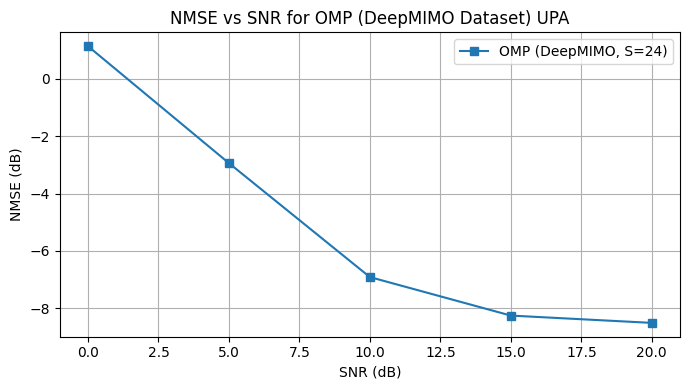

In [96]:
# PLOT
plt.figure(figsize=(7,4))
plt.plot(snr_db, nmse_db_omp_upa, 's-', label=f'OMP (DeepMIMO, S={S})')
plt.xlabel("SNR (dB)")
plt.ylabel("NMSE (dB)")
plt.title("NMSE vs SNR for OMP (DeepMIMO Dataset) UPA")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


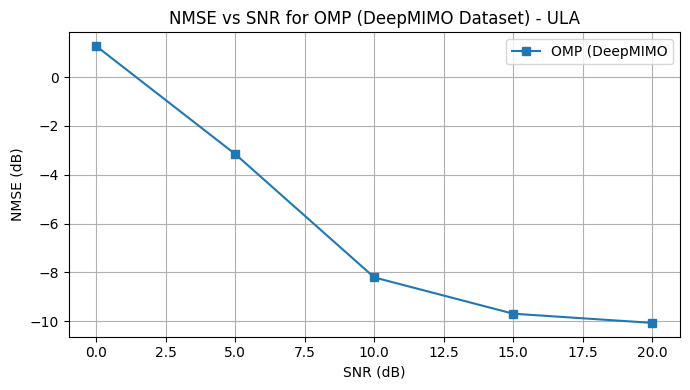

In [108]:
#working code for DeepMIMO - OMP - ULA

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# PARAMETERS
N_samples = 543
Nx, Ny = 256, 1
N = Nx * Ny
M = 128
S = 24
snr_db = np.arange(0, 21, 5)

np.random.seed(0)

# SELECTION MATRIX A (±1/√M)
A = np.random.choice([1/np.sqrt(M), -1/np.sqrt(M)], size=(M, N))

# DFT MATRIX U for ULA
U = np.fft.fft(np.eye(N), norm='ortho')


# LOAD DeepMIMO DATASET
data = pd.read_csv('beamspace_unet_dataset.csv')

h_real = data.iloc[:, 2*M : 2*M+N].values
h_imag = data.iloc[:, 2*M+N : 2*M+2*N].values
h_spatial = h_real + 1j * h_imag
if h_spatial.shape[0] > N_samples:
    h_spatial = h_spatial[:N_samples, :]
elif h_spatial.shape[0] < N_samples:
    raise ValueError(f"Dataset only has {h_spatial.shape[0]} samples!")

# Normalizing h_spatial
norm_factors = np.linalg.norm(h_spatial, axis=1, keepdims=True)
h_spatial = np.sqrt(N) * h_spatial / norm_factors


# Compute beamspace channel
h_beam = (U @ h_spatial.T).T

S_sparse = 28
for i in range(h_beam.shape[0]):
    abs_vals = np.abs(h_beam[i])
    threshold = np.partition(abs_vals, -S_sparse)[-S_sparse]
    h_beam[i][abs_vals < threshold] = 0

y_clean = (A @ h_beam.T).T

# OMP FUNCTION
def omp(y, A, S):
    residual = y.copy()
    support = []
    x_hat = np.zeros(A.shape[1], dtype=complex)
    for _ in range(S):
        corr = A.conj().T @ residual
        idx = np.argmax(np.abs(corr))
        if idx in support:
            break
        support.append(idx)
        A_sub = A[:, support]
        x_sub, *_ = np.linalg.lstsq(A_sub, y, rcond=None)
        residual = y - A_sub @ x_sub
    x_hat[support] = x_sub
    return x_hat

# SWEEPING SNR AND COMPUTING NMSE
nmse_db_omp_ula = []

for db in snr_db:
    snr_lin = 10**(db/10)
    sigma = np.sqrt(1/(2*snr_lin))
    errors = []
    for i in range(N_samples):
        noise = (np.random.randn(M) + 1j*np.random.randn(M)) * sigma
        y_noisy = y_clean[i] + noise

        h_est_beam = omp(y_noisy, A, S)
        h_true_beam = h_beam[i]

        errors.append(np.linalg.norm(h_est_beam - h_true_beam)**2
                      / np.linalg.norm(h_true_beam)**2)
    nmse_db_omp_ula.append(10*np.log10(np.mean(errors)))

# PLOT
plt.figure(figsize=(7,4))
plt.plot(snr_db, nmse_db_omp_ula, 's-', label=f'OMP (DeepMIMO')
plt.xlabel("SNR (dB)")
plt.ylabel("NMSE (dB)")
plt.title("NMSE vs SNR for OMP (DeepMIMO Dataset) - ULA")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


##

In [91]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

# === PARAMETERS ===
M = 128  # Measurements
N = 256  # Antennas
snr_db = np.arange(0, 21, 5)  # SNRs
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load Dataset
data = pd.read_csv('beamspace_unet_dataset.csv')

# Channels
h_real = data.iloc[:, 2*M : 2*M+N].values
h_imag = data.iloc[:, 2*M+N : 2*M+2*N].values
h_spatial = h_real + 1j * h_imag
N_samples = h_spatial.shape[0]

# Normalize h_spatial
norm_factors = np.linalg.norm(h_spatial, axis=1, keepdims=True)
h_spatial = np.sqrt(N) * h_spatial / norm_factors

# DFT Lens Matrix U
U = np.fft.fft(np.eye(N), norm='ortho')

# Compute beamspace channels
h_beamspace = (U @ h_spatial.T).T
S_sparse = 50
for i in range(N_samples):
    abs_vals = np.abs(h_beamspace[i])
    threshold = np.partition(abs_vals, -S_sparse)[-S_sparse]
    h_beamspace[i][abs_vals < threshold] = 0

# Generate New Measurements
A = np.random.choice([1/np.sqrt(M), -1/np.sqrt(M)], size=(M, N))
y_clean = (A @ h_beamspace.T).T

# INPUT FEATURES
y_real = np.real(y_clean)
y_imag = np.imag(y_clean)
y_amp  = np.abs(y_clean)
y_phase= np.angle(y_clean)

x_input = np.stack([y_real, y_imag, y_amp, y_phase], axis=-1)

# ATTENTION U-NET MO
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

class AttentionBlock(nn.Module):
    def __init__(self, channels):
        super(AttentionBlock, self).__init__()
        self.qkv = nn.Conv1d(channels, channels * 3, kernel_size=1)
        self.scale = math.sqrt(channels)

    def forward(self, x):
        B, C, L = x.shape
        qkv = self.qkv(x)
        q, k, v = torch.chunk(qkv, 3, dim=1)
        attn = torch.softmax(torch.bmm(q.transpose(1,2), k) / self.scale, dim=-1)
        out = torch.bmm(attn, v.transpose(1,2)).transpose(1,2)
        return x + out

class ResidualBlockWithAttention(nn.Module):
    def __init__(self, channels, dropout=0.1):
        super(ResidualBlockWithAttention, self).__init__()
        self.norm1 = nn.GroupNorm(8, channels)
        self.swish1 = Swish()
        self.conv1 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)

        self.norm2 = nn.GroupNorm(8, channels)
        self.swish2 = Swish()
        self.dropout = nn.Dropout(dropout)
        self.conv2 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)

        self.attention = AttentionBlock(channels)

    def forward(self, x):
        identity = x
        x = self.norm1(x)
        x = self.swish1(x)
        x = self.conv1(x)

        x = self.norm2(x)
        x = self.swish2(x)
        x = self.dropout(x)
        x = self.conv2(x)

        x = x + identity
        x = self.attention(x)
        return x

class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EncoderBlock, self).__init__()
        self.downsample = nn.Conv1d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)
        self.residual_block = ResidualBlockWithAttention(out_channels)

    def forward(self, x):
        x = self.downsample(x)
        x = self.residual_block(x)
        return x

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DecoderBlock, self).__init__()
        self.upsample = nn.ConvTranspose1d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)
        self.residual_block = ResidualBlockWithAttention(out_channels)

    def forward(self, x, skip):
        x = self.upsample(x)
        x = x + skip
        x = self.residual_block(x)
        return x

class AttentionUNet(nn.Module):
    def __init__(self, input_dim, base_channels=32):
        super(AttentionUNet, self).__init__()
        self.fc = nn.Linear(input_dim, input_dim * 2)
        self.init_conv = nn.Conv1d(4, base_channels, kernel_size=3, padding=1)

        self.enc1 = EncoderBlock(base_channels, base_channels)
        self.enc2 = EncoderBlock(base_channels, base_channels * 2)
        self.enc3 = EncoderBlock(base_channels * 2, base_channels * 4)

        self.bottleneck = ResidualBlockWithAttention(base_channels * 4)

        self.dec1 = DecoderBlock(base_channels * 4, base_channels * 2)
        self.dec2 = DecoderBlock(base_channels * 2, base_channels)
        self.dec3 = DecoderBlock(base_channels, base_channels)

        self.final_upsample = nn.ConvTranspose1d(base_channels, base_channels, kernel_size=4, stride=2, padding=1)
        self.final_conv = nn.Conv1d(base_channels, 2, kernel_size=1)

    def forward(self, y_fc_input, x_input):
        _ = self.fc(y_fc_input)
        x = self.init_conv(x_input)
        e1 = self.enc1(x)
        e2 = self.enc2(e1)
        e3 = self.enc3(e2)
        b = self.bottleneck(e3)
        d1 = self.dec1(b, e2)
        d2 = self.dec2(d1, e1)
        d3 = self.dec3(d2, x)
        d3 = self.final_upsample(d3)
        out = self.final_conv(d3)
        return out


Using device: cpu


In [92]:

x_input_tensor = torch.tensor(x_input, dtype=torch.float32).permute(0,2,1)
y_fc_input_tensor = torch.tensor(y_amp, dtype=torch.float32)

# Target: real and imag parts of h_beamspace
h_target_tensor = torch.stack([torch.tensor(h_beamspace.real, dtype=torch.float32),
                               torch.tensor(h_beamspace.imag, dtype=torch.float32)], dim=-1)

# Train/Val Split
train_size = int(0.8 * N_samples)
val_size = N_samples - train_size
train_x, val_x = torch.utils.data.random_split(range(N_samples), [train_size, val_size])

train_dataset = TensorDataset(y_fc_input_tensor[train_x], x_input_tensor[train_x], h_target_tensor[train_x])
val_dataset   = TensorDataset(y_fc_input_tensor[val_x], x_input_tensor[val_x], h_target_tensor[val_x])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Creating Model
model = AttentionUNet(input_dim=M).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
loss_fn = nn.MSELoss()

# Training Loop
epochs = 200
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for y_fc_batch, x_batch, h_batch in train_loader:
        y_fc_batch = y_fc_batch.to(device)
        x_batch = x_batch.to(device)
        h_batch = h_batch.to(device)

        optimizer.zero_grad()
        pred = model(y_fc_batch, x_batch)
        pred = pred.permute(0,2,1)

        loss = loss_fn(pred, h_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    scheduler.step()

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for y_fc_batch, x_batch, h_batch in val_loader:
            y_fc_batch = y_fc_batch.to(device)
            x_batch = x_batch.to(device)
            h_batch = h_batch.to(device)

            pred = model(y_fc_batch, x_batch)
            pred = pred.permute(0,2,1)

            loss = loss_fn(pred, h_batch)
            val_loss += loss.item()

    if epoch % 10 == 0 or epoch == epochs-1:
        print(f"Epoch [{epoch+1}/{epochs}]  Train Loss: {train_loss/len(train_loader):.5f}  Val Loss: {val_loss/len(val_loader):.5f}")


Epoch [1/200]  Train Loss: 0.32813  Val Loss: 0.31266
Epoch [11/200]  Train Loss: 0.12376  Val Loss: 0.11993
Epoch [21/200]  Train Loss: 0.08389  Val Loss: 0.09474
Epoch [31/200]  Train Loss: 0.06671  Val Loss: 0.08678
Epoch [41/200]  Train Loss: 0.05628  Val Loss: 0.08144
Epoch [51/200]  Train Loss: 0.04867  Val Loss: 0.07878
Epoch [61/200]  Train Loss: 0.04275  Val Loss: 0.07619
Epoch [71/200]  Train Loss: 0.03754  Val Loss: 0.07418
Epoch [81/200]  Train Loss: 0.03314  Val Loss: 0.07234
Epoch [91/200]  Train Loss: 0.02905  Val Loss: 0.07037
Epoch [101/200]  Train Loss: 0.02584  Val Loss: 0.06949
Epoch [111/200]  Train Loss: 0.02304  Val Loss: 0.06854
Epoch [121/200]  Train Loss: 0.02089  Val Loss: 0.06799
Epoch [131/200]  Train Loss: 0.01932  Val Loss: 0.06729
Epoch [141/200]  Train Loss: 0.01803  Val Loss: 0.06671
Epoch [151/200]  Train Loss: 0.01711  Val Loss: 0.06639
Epoch [161/200]  Train Loss: 0.01654  Val Loss: 0.06630
Epoch [171/200]  Train Loss: 0.01604  Val Loss: 0.06617
Epo

In [ ]:
# Evaluate NMSE across SNRs
nmse_db = []

model.eval()
with torch.no_grad():
    for db in np.arange(0, 21, 5):  # 0 to 20 dB
        snr_lin = 10**(db/10)
        sigma = np.sqrt(1/(2*snr_lin))

        noisy_inputs = []
        fc_inputs = []
        true_channels = []

        for idx in range(N_samples):
            noise = (np.random.randn(M) + 1j*np.random.randn(M)) * sigma
            y_noisy = y_clean[idx] + noise

            y_real = y_noisy.real
            y_imag = y_noisy.imag
            y_amp  = np.abs(y_noisy)
            y_phase= np.angle(y_noisy)

            x_input_single = np.stack([y_real, y_imag, y_amp, y_phase], axis=0)
            fc_input_single = y_amp

            noisy_inputs.append(x_input_single)
            fc_inputs.append(fc_input_single)
            true_channels.append(h_beamspace[idx])

        x_input_batch = torch.tensor(np.stack(noisy_inputs), dtype=torch.float32).to(device)
        fc_input_batch = torch.tensor(np.stack(fc_inputs), dtype=torch.float32).to(device)

        pred = model(fc_input_batch, x_input_batch)
        pred = pred.permute(0,2,1)

        pred_complex = pred[:,:,0].cpu().numpy() + 1j * pred[:,:,1].cpu().numpy()

        nmse_linear_list = []
        for i in range(N_samples):
            error = np.linalg.norm(pred_complex[i] - true_channels[i])**2
            power = np.linalg.norm(true_channels[i])**2
            nmse_linear_list.append(error / power)

        nmse_avg_linear = np.mean(nmse_linear_list)
        nmse_avg_db = 10 * np.log10(nmse_avg_linear)
        nmse_db.append(nmse_avg_db)


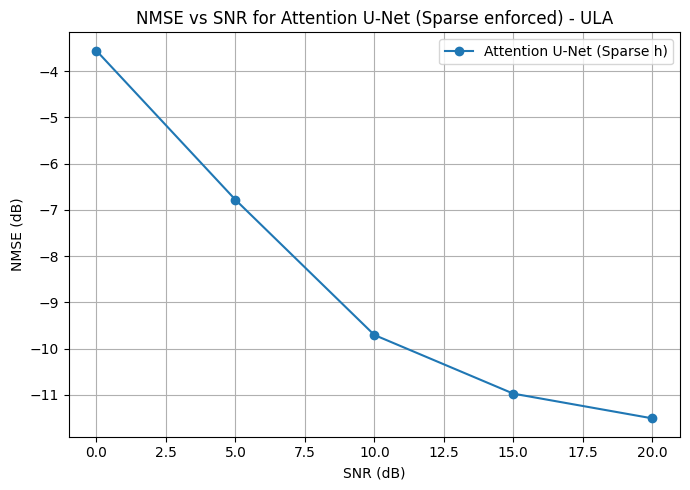

In [105]:
# Plot NMSE vs SNR
plt.figure(figsize=(7,5))
plt.plot(np.arange(0, 21, 5), nmse_db, 'o-', label='Attention U-Net (Sparse h)')
plt.xlabel('SNR (dB)')
plt.ylabel('NMSE (dB)')
plt.title('NMSE vs SNR for Attention U-Net (Sparse enforced) - ULA')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


##FOR UPA

In [97]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

# PARAMETERS
M = 128
Nx, Ny = 16, 16  # 16×16 UPA
N = Nx * Ny
S_sparse = 24
snr_db = np.arange(0, 21, 5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load Dataset
data = pd.read_csv('beamspace_unet_dataset.csv')

h_real = data.iloc[:, 2*M : 2*M+N].values
h_imag = data.iloc[:, 2*M+N : 2*M+2*N].values
h_spatial = h_real + 1j * h_imag
N_samples = h_spatial.shape[0]

# Normalize h_spatial
norm_factors = np.linalg.norm(h_spatial, axis=1, keepdims=True)
h_spatial = np.sqrt(N) * h_spatial / norm_factors

# 2D DFT Lens Matrix U
Ux = np.fft.fft(np.eye(Nx), norm='ortho')
Uy = np.fft.fft(np.eye(Ny), norm='ortho')
U = np.kron(Uy, Ux)

# Computing beamspace channels
h_beamspace = (U @ h_spatial.T).T
for i in range(N_samples):
    abs_vals = np.abs(h_beamspace[i])
    threshold = np.partition(abs_vals, -S_sparse)[-S_sparse]
    h_beamspace[i][abs_vals < threshold] = 0

A = np.random.choice([1/np.sqrt(M), -1/np.sqrt(M)], size=(M, N))
y_clean = (A @ h_beamspace.T).T

# INPUT FEATURES: 4 channels
y_real = np.real(y_clean)
y_imag = np.imag(y_clean)
y_amp  = np.abs(y_clean)
y_phase= np.angle(y_clean)

x_input = np.stack([y_real, y_imag, y_amp, y_phase], axis=-1)

# ATTENTION U-NET MODEL
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

class AttentionBlock(nn.Module):
    def __init__(self, channels):
        super(AttentionBlock, self).__init__()
        self.qkv = nn.Conv1d(channels, channels * 3, kernel_size=1)
        self.scale = math.sqrt(channels)

    def forward(self, x):
        B, C, L = x.shape
        qkv = self.qkv(x)
        q, k, v = torch.chunk(qkv, 3, dim=1)
        attn = torch.softmax(torch.bmm(q.transpose(1,2), k) / self.scale, dim=-1)
        out = torch.bmm(attn, v.transpose(1,2)).transpose(1,2)
        return x + out

class ResidualBlockWithAttention(nn.Module):
    def __init__(self, channels, dropout=0.1):
        super(ResidualBlockWithAttention, self).__init__()
        self.norm1 = nn.GroupNorm(8, channels)
        self.swish1 = Swish()
        self.conv1 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)

        self.norm2 = nn.GroupNorm(8, channels)
        self.swish2 = Swish()
        self.dropout = nn.Dropout(dropout)
        self.conv2 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)

        self.attention = AttentionBlock(channels)

    def forward(self, x):
        identity = x
        x = self.norm1(x)
        x = self.swish1(x)
        x = self.conv1(x)

        x = self.norm2(x)
        x = self.swish2(x)
        x = self.dropout(x)
        x = self.conv2(x)

        x = x + identity
        x = self.attention(x)
        return x

class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EncoderBlock, self).__init__()
        self.downsample = nn.Conv1d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)
        self.residual_block = ResidualBlockWithAttention(out_channels)

    def forward(self, x):
        x = self.downsample(x)
        x = self.residual_block(x)
        return x

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DecoderBlock, self).__init__()
        self.upsample = nn.ConvTranspose1d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)
        self.residual_block = ResidualBlockWithAttention(out_channels)

    def forward(self, x, skip):
        x = self.upsample(x)
        x = x + skip
        x = self.residual_block(x)
        return x

class AttentionUNet(nn.Module):
    def __init__(self, input_dim, base_channels=32):
        super(AttentionUNet, self).__init__()
        self.fc = nn.Linear(input_dim, input_dim * 2)
        self.init_conv = nn.Conv1d(4, base_channels, kernel_size=3, padding=1)

        self.enc1 = EncoderBlock(base_channels, base_channels)
        self.enc2 = EncoderBlock(base_channels, base_channels * 2)
        self.enc3 = EncoderBlock(base_channels * 2, base_channels * 4)

        self.bottleneck = ResidualBlockWithAttention(base_channels * 4)

        self.dec1 = DecoderBlock(base_channels * 4, base_channels * 2)
        self.dec2 = DecoderBlock(base_channels * 2, base_channels)
        self.dec3 = DecoderBlock(base_channels, base_channels)

        self.final_upsample = nn.ConvTranspose1d(base_channels, base_channels, kernel_size=4, stride=2, padding=1)
        self.final_conv = nn.Conv1d(base_channels, 2, kernel_size=1)

    def forward(self, y_fc_input, x_input):
        _ = self.fc(y_fc_input)
        x = self.init_conv(x_input)
        e1 = self.enc1(x)
        e2 = self.enc2(e1)
        e3 = self.enc3(e2)
        b = self.bottleneck(e3)
        d1 = self.dec1(b, e2)
        d2 = self.dec2(d1, e1)
        d3 = self.dec3(d2, x)
        d3 = self.final_upsample(d3)
        out = self.final_conv(d3)
        return out


Using device: cpu


In [98]:

x_input_tensor = torch.tensor(x_input, dtype=torch.float32).permute(0,2,1)
y_fc_input_tensor = torch.tensor(y_amp, dtype=torch.float32)

# Target: real and imag parts of h_beamspace
h_target_tensor = torch.stack([torch.tensor(h_beamspace.real, dtype=torch.float32),
                               torch.tensor(h_beamspace.imag, dtype=torch.float32)], dim=-1)

# Train/Val Split
train_size = int(0.8 * N_samples)
val_size = N_samples - train_size
train_x, val_x = torch.utils.data.random_split(range(N_samples), [train_size, val_size])

train_dataset = TensorDataset(y_fc_input_tensor[train_x], x_input_tensor[train_x], h_target_tensor[train_x])
val_dataset   = TensorDataset(y_fc_input_tensor[val_x], x_input_tensor[val_x], h_target_tensor[val_x])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Creating Model
model = AttentionUNet(input_dim=M).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
loss_fn = nn.MSELoss()

# Training Loop
epochs = 200
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for y_fc_batch, x_batch, h_batch in train_loader:
        y_fc_batch = y_fc_batch.to(device)
        x_batch = x_batch.to(device)
        h_batch = h_batch.to(device)

        optimizer.zero_grad()
        pred = model(y_fc_batch, x_batch)
        pred = pred.permute(0,2,1)

        loss = loss_fn(pred, h_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    scheduler.step()

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for y_fc_batch, x_batch, h_batch in val_loader:
            y_fc_batch = y_fc_batch.to(device)
            x_batch = x_batch.to(device)
            h_batch = h_batch.to(device)

            pred = model(y_fc_batch, x_batch)
            pred = pred.permute(0,2,1)

            loss = loss_fn(pred, h_batch)
            val_loss += loss.item()

    if epoch % 10 == 0 or epoch == epochs-1:
        print(f"Epoch [{epoch+1}/{epochs}]  Train Loss: {train_loss/len(train_loader):.5f}  Val Loss: {val_loss/len(val_loader):.5f}")


Epoch [1/200]  Train Loss: 0.24598  Val Loss: 0.22122
Epoch [11/200]  Train Loss: 0.08677  Val Loss: 0.09139
Epoch [21/200]  Train Loss: 0.06539  Val Loss: 0.07694
Epoch [31/200]  Train Loss: 0.05254  Val Loss: 0.06889
Epoch [41/200]  Train Loss: 0.04150  Val Loss: 0.06399
Epoch [51/200]  Train Loss: 0.03308  Val Loss: 0.06019
Epoch [61/200]  Train Loss: 0.02741  Val Loss: 0.05841
Epoch [71/200]  Train Loss: 0.02311  Val Loss: 0.05674
Epoch [81/200]  Train Loss: 0.01997  Val Loss: 0.05579
Epoch [91/200]  Train Loss: 0.01789  Val Loss: 0.05512
Epoch [101/200]  Train Loss: 0.01638  Val Loss: 0.05443
Epoch [111/200]  Train Loss: 0.01489  Val Loss: 0.05443
Epoch [121/200]  Train Loss: 0.01390  Val Loss: 0.05388
Epoch [131/200]  Train Loss: 0.01305  Val Loss: 0.05318
Epoch [141/200]  Train Loss: 0.01229  Val Loss: 0.05312
Epoch [151/200]  Train Loss: 0.01195  Val Loss: 0.05295
Epoch [161/200]  Train Loss: 0.01163  Val Loss: 0.05291
Epoch [171/200]  Train Loss: 0.01146  Val Loss: 0.05281
Epo

In [99]:
# Evaluate NMSE across SNRs
nmse_db_unet_upa = []

model.eval()
with torch.no_grad():
    for db in np.arange(0, 21, 5):  # 0 to 20 dB
        snr_lin = 10**(db/10)
        sigma = np.sqrt(1/(2*snr_lin))

        noisy_inputs = []
        fc_inputs = []
        true_channels = []

        for idx in range(N_samples):
            noise = (np.random.randn(M) + 1j*np.random.randn(M)) * sigma
            y_noisy = y_clean[idx] + noise

            y_real = y_noisy.real
            y_imag = y_noisy.imag
            y_amp  = np.abs(y_noisy)
            y_phase= np.angle(y_noisy)

            x_input_single = np.stack([y_real, y_imag, y_amp, y_phase], axis=0)
            fc_input_single = y_amp

            noisy_inputs.append(x_input_single)
            fc_inputs.append(fc_input_single)
            true_channels.append(h_beamspace[idx])

        x_input_batch = torch.tensor(np.stack(noisy_inputs), dtype=torch.float32).to(device)
        fc_input_batch = torch.tensor(np.stack(fc_inputs), dtype=torch.float32).to(device)

        pred = model(fc_input_batch, x_input_batch)
        pred = pred.permute(0,2,1)

        pred_complex = pred[:,:,0].cpu().numpy() + 1j * pred[:,:,1].cpu().numpy()

        nmse_linear_list = []
        for i in range(N_samples):
            error = np.linalg.norm(pred_complex[i] - true_channels[i])**2
            power = np.linalg.norm(true_channels[i])**2
            nmse_linear_list.append(error / power)

        nmse_avg_linear = np.mean(nmse_linear_list)
        nmse_avg_db = 10 * np.log10(nmse_avg_linear)
        nmse_db_unet_upa.append(nmse_avg_db)




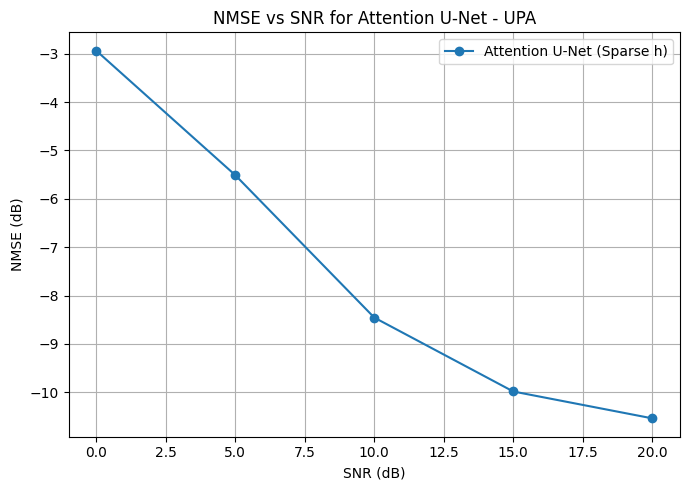

In [100]:
# Plot NMSE vs SNR
plt.figure(figsize=(7,5))
plt.plot(np.arange(0, 21, 5), nmse_db_unet_upa, 'o-', label='Attention U-Net (Sparse h)')
plt.xlabel('SNR (dB)')
plt.ylabel('NMSE (dB)')
plt.title('NMSE vs SNR for Attention U-Net - UPA')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

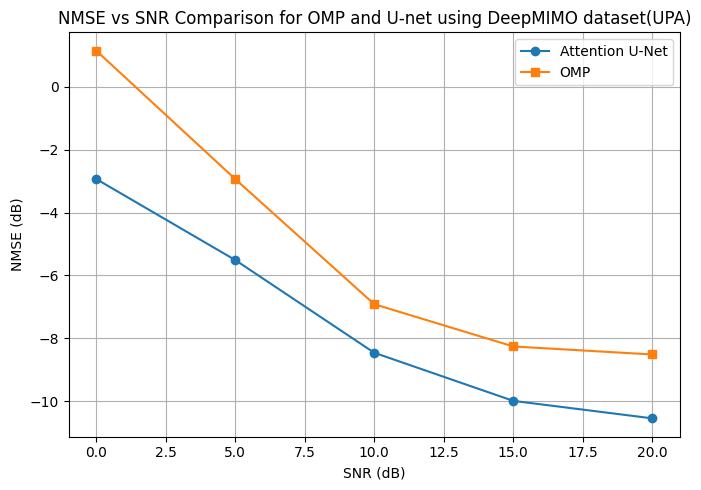

In [104]:
#  Combined NMSE vs SNR plot (Attention U-Net + OMP)
plt.figure(figsize=(7,5))

plt.plot(np.arange(0, 21, 5), nmse_db_unet_upa, 'o-', label='Attention U-Net')
plt.plot(np.arange(0, 21, 5), nmse_db_omp_upa, 's-', label=f'OMP')
plt.xlabel('SNR (dB)')
plt.ylabel('NMSE (dB)')
plt.title('NMSE vs SNR Comparison for OMP and U-net using DeepMIMO dataset(UPA)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


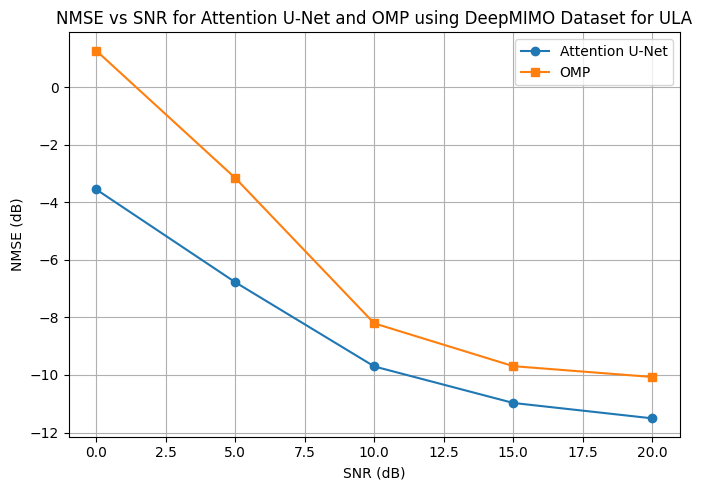

In [109]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(7,5))

plt.plot(np.arange(0, 21, 5), nmse_db, 'o-', label='Attention U-Net')
plt.plot(snr_db, nmse_db_omp_ula, 's-', label='OMP')
plt.xlabel('SNR (dB)')
plt.ylabel('NMSE (dB)')
plt.title('NMSE vs SNR for Attention U-Net and OMP using DeepMIMO Dataset for ULA')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
